In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
!pip install facenet-pytorch

In [ ]:
!pip install retina-face

In [ ]:
!mkdir /content/model
!wget https://github.com/buzziru/DL_FACE_REC/raw/main/model/age_model_checkpoint_epoch_10_loss_4.57.pth -O /content/model/age_model.pth
!wget https://github.com/buzziru/DL_FACE_REC/raw/main/model/gender_model_v3_checkpoint_epoch_19.pth -O /content/model/gender_model.pth

--2024-03-04 10:56:16--  https://github.com/buzziru/DL_FACE_REC/raw/main/model/age_model_checkpoint_epoch_10_loss_4.57.pth
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/buzziru/DL_FACE_REC/main/model/age_model_checkpoint_epoch_10_loss_4.57.pth [following]
--2024-03-04 10:56:16--  https://media.githubusercontent.com/media/buzziru/DL_FACE_REC/main/model/age_model_checkpoint_epoch_10_loss_4.57.pth
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114505224 (109M) [application/octet-stream]
Saving to: ‘/content/model/age_model.pth’

/content/model/age_ 100%[===================>] 109.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# 모델 생성

In [ ]:
from facenet_pytorch import InceptionResnetV1

def make_age_model():
    model = InceptionResnetV1(classify=True, pretrained='vggface2', num_classes=1)
    in_dim = model.logits.in_features
    model.logits = nn.Linear(in_dim, 1)
    return model

def load_model(model, path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

age = make_age_model()

age_model_path = '/content/model/age_model.pth'
age_model = load_model(age, age_model_path)

In [ ]:
class Gender_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3)
        self.bn5 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)

        self.fc1 = nn.Linear(512 * 4 * 4, 512)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))

        x = x.view(-1, 512 * 4 * 4)
        x = F.relu(self.fc1(self.dropout(x)))
        x = self.fc2(x)
        x = x.squeeze()
        return x

gender_model_path = '/content/model/gender_model.pth'
gender = Gender_Net()
gender_model = load_model(gender, gender_model_path)

In [ ]:
def process_input(img, box):
    img_ar = img[box[1]:box[1]+box[3], box[0]:box[0]+box[2]]
    image = Image.fromarray(img_ar)

    # 모델의 input에 맞게 전처리
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.6284, 0.4901, 0.4325], std=[0.1869, 0.1712, 0.1561]),
    ])
    img_tensor = preprocess(image).unsqueeze(0)  # 배치 차원 추가
    return img_tensor

In [ ]:
def predict_age(image, model):
    image = image.to(device)
    model = model.to(device)

    model.eval()
    with torch.no_grad():
        prediction = model(image)

    return prediction.item()

In [ ]:
def predict_gender(image, model):
    image = image.to(device)
    model = model.to(device)

    model.eval()
    with torch.no_grad():
        logit = model(image)
        pred = torch.sigmoid(logit)
        output = 'male' if pred.item() < 0.5 else 'female'

    return output

In [ ]:
!mkdir /content/data
!wget http://www.irobotnews.com/news/photo/202310/32983_70512_3222.png -O /content/data/child.png

--2024-03-04 11:36:41--  http://www.irobotnews.com/news/photo/202310/32983_70512_3222.png
Resolving www.irobotnews.com (www.irobotnews.com)... 114.200.196.64
Connecting to www.irobotnews.com (www.irobotnews.com)|114.200.196.64|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353217 (345K) [image/png]
Saving to: ‘/content/data/child.png’

/content/data/child 100%[===================>] 344.94K   167KB/s    in 2.1s    

2024-03-04 11:36:43 (167 KB/s) - ‘/content/data/child.png’ saved [353217/353217]



# 이미지 시각화

In [ ]:
from retinaface import RetinaFace

image_path = '/content/data/child.png'

In [ ]:
# def adjust_font_scale(image_width, base_width=1000, base_scale=0.5):
#     scale_ratio = image_width / base_width
#     return base_scale * scale_ratio

In [ ]:
def visualize_predictions(image_path, age_model, gender_model):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # image_height, image_width, _ = img_rgb.shape
    # font_scale = adjust_font_scale(image_width)

    resp = RetinaFace.detect_faces(img_rgb)

    fig, ax = plt.subplots(1, figsize=(10, 8))
    green_rgb = (125, 255, 51)
    red_rgb = (255, 50, 50)

    for face in resp.values():
        box = face['facial_area']
        img_tensor = process_input(img_rgb, box)

        age = int(predict_age(img_tensor, age_model))
        gender = predict_gender(img_tensor, gender_model)

        cv2.rectangle(img_rgb, (box[0], box[1]), (box[2], box[3]), color=green_rgb, thickness=1)
        text = "Gender : {}, Age : {}".format(gender, age)
        cv2.putText(img_rgb, text, (box[0]-30, box[1]+2), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color=red_rgb, thickness=1)

    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

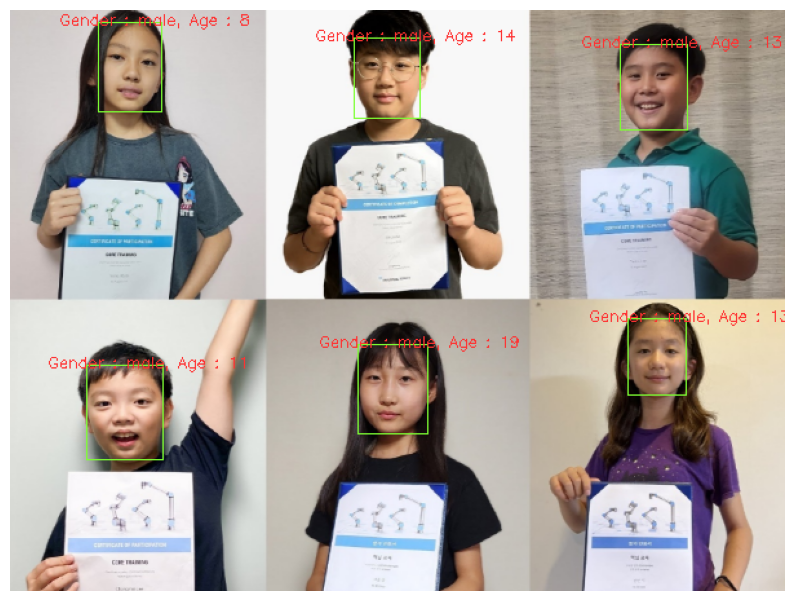

In [ ]:
visualize_predictions(image_path, age_model, gender_model)

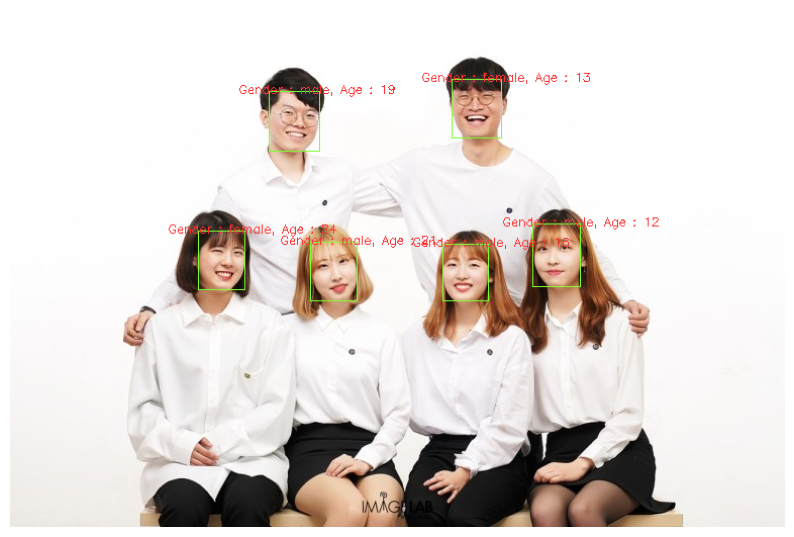

In [ ]:
image_path = '/content/data/대학생.jpg'
visualize_predictions(image_path, age_model, gender_model)

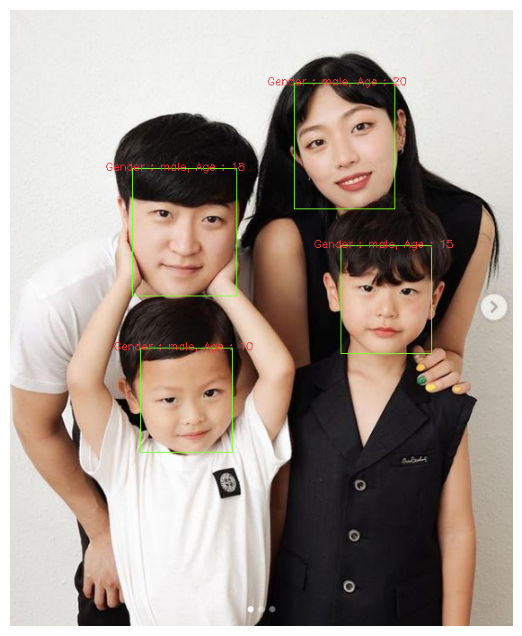

In [ ]:
image_path = '/content/data/부부.jpg'
visualize_predictions(image_path, age_model, gender_model)

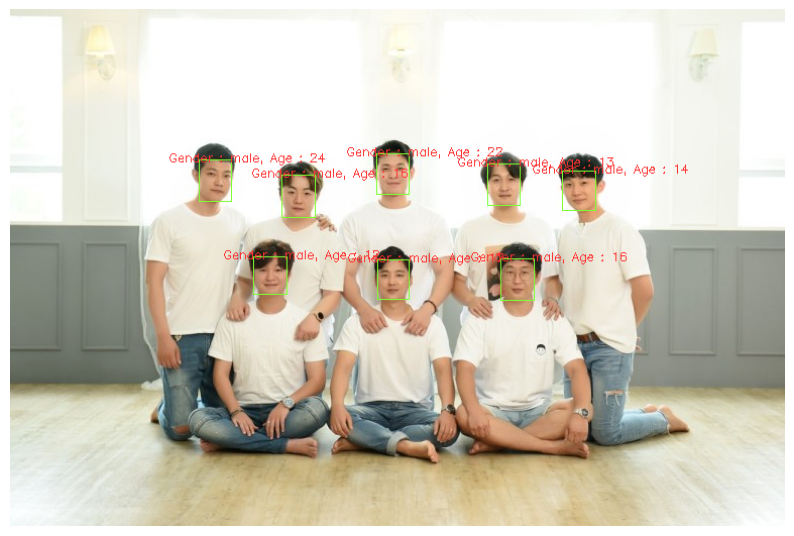

In [ ]:
image_path = '/content/data/남자 단체.jpg'
visualize_predictions(image_path, age_model, gender_model)

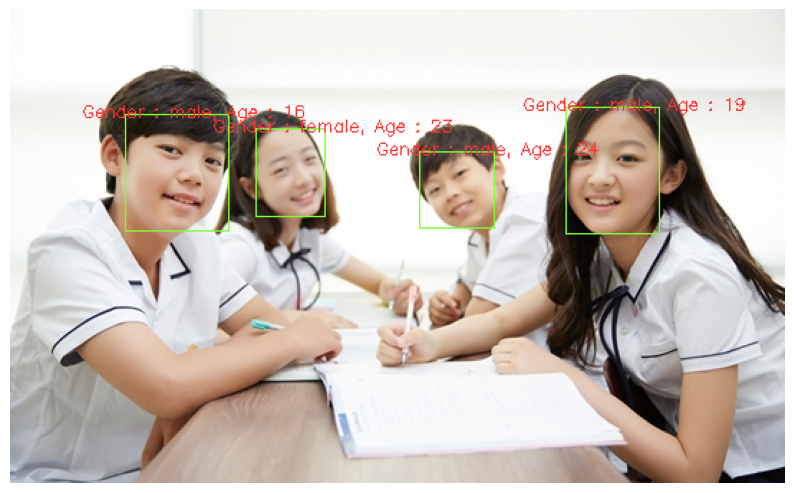

In [ ]:
image_path = '/content/data/중학생.jpg'
visualize_predictions(image_path, age_model, gender_model)

- 여성을 잘 예측하지 못함

# 동영상 시각화

In [ ]:
!mkdir /content/output/

In [ ]:
!pip install youtube-dl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.7 MB/s eta 0:00:00


In [ ]:
import time

video_input_path = '/content/data/테스트_영상.mp4'
video_output_path = '/content/output/test_output.mp4'

cap = cv2.VideoCapture(video_input_path)
codec = cv2.VideoWriter_fourcc(*'mp4v')

vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
vid_fps = cap.get(cv2.CAP_PROP_FPS )

vid_writer = cv2.VideoWriter(video_output_path, codec, vid_fps, vid_size)

frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print('총 Frame 갯수:', frame_cnt, 'FPS:', round(vid_fps), 'Frame 크기:', vid_size)

총 Frame 갯수: 23432 FPS: 30 Frame 크기: (1280, 720)


In [ ]:
green_color=(0, 255, 0)
red_color=(0, 0, 255)

start = time.time()
index=0
while True:
    hasFrame, img_frame = cap.read()
    img_frame_rgb = cv2.cvtColor(img_frame, cv2.COLOR_BGR2RGB)
    if not hasFrame or index >= 600:
        print('더 이상 처리할 frame이 없습니다.')
        break
    index += 1
    if index % 10 == 0:
        print('frame :', index, '처리 완료')

    resp = RetinaFace.detect_faces(img_frame_rgb)

    for face in resp.values():
        box = face['facial_area']
        img_tensor = process_input(img_frame_rgb, box)

        age = int(predict_age(img_tensor, age_model))
        gender = predict_gender(img_tensor, gender_model)

        cv2.rectangle(img_frame_rgb, (box[0], box[1]), (box[2], box[3]), color=green_color, thickness=1)
        text = "Gender : {}, Age : {}".format(gender, age)
        cv2.putText(img_frame_rgb, text, (box[0]-30, box[1]+2), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color=red_color, thickness=1)

    img_frame_bgr = cv2.cvtColor(img_frame_rgb, cv2.COLOR_RGB2BGR)
    vid_writer.write(img_frame_bgr)

print('write 완료 시간:', round(time.time()-start,4))
vid_writer.release()
cap.release()

frame : 10 처리 완료
frame : 20 처리 완료
frame : 30 처리 완료
frame : 40 처리 완료
frame : 50 처리 완료
frame : 60 처리 완료
frame : 70 처리 완료
frame : 80 처리 완료
frame : 90 처리 완료
frame : 100 처리 완료
frame : 110 처리 완료
frame : 120 처리 완료
frame : 130 처리 완료
frame : 140 처리 완료
frame : 150 처리 완료
frame : 160 처리 완료
frame : 170 처리 완료
frame : 180 처리 완료
frame : 190 처리 완료
frame : 200 처리 완료
frame : 210 처리 완료
frame : 220 처리 완료
frame : 230 처리 완료
frame : 240 처리 완료
frame : 250 처리 완료
frame : 260 처리 완료
frame : 270 처리 완료
frame : 280 처리 완료
frame : 290 처리 완료
frame : 300 처리 완료
frame : 310 처리 완료
frame : 320 처리 완료
frame : 330 처리 완료
frame : 340 처리 완료
frame : 350 처리 완료
frame : 360 처리 완료
frame : 370 처리 완료
frame : 380 처리 완료
frame : 390 처리 완료
frame : 400 처리 완료
frame : 410 처리 완료
frame : 420 처리 완료
frame : 430 처리 완료
frame : 440 처리 완료
frame : 450 처리 완료
frame : 460 처리 완료
frame : 470 처리 완료
frame : 480 처리 완료
frame : 490 처리 완료
frame : 500 처리 완료
frame : 510 처리 완료
frame : 520 처리 완료
frame : 530 처리 완료
frame : 540 처리 완료
frame : 550 처리 완료
frame : 560 처리 완료
f